In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import warnings

warnings.filterwarnings('ignore')
plt.ion();

# Trabalho Final de Aprendizado de Máquina - League of Legends
---
_O quanto um modelo de aprendizado supervisionado é capaz de prever o time vencedor de uma partida profissional de League of Legends, baseando-se apenas em informações do começo do jogo? Isto é, uma vantagem criada no começo do jogo e composições de equipe são suficientes para ditar o resultado de uma partida?_

---

Como conjunto de dados, temos informações de partidas de ligas profissionais e campeonatos internacionais oficiais disputadas de 2016 e 2017, totalizando 7620 observações. (Disponível em https://www.kaggle.com/chuckephron/leagueoflegends - Acesso em 25/06/2019) As informações incluem os campeões escolhidos por ambos os times, e valores como diferença de ouro e conquista de objetivos por minuto de jogo. 

Usando todos os atributos disponíveis sobre as partidas (isto é, o placar no decorrer do jogo), a previsão do time vencedor torna-se trivial. O objetivo do trabalho é investigar a capacidade de solução desse problema a partir da abordagem de aprendizado supervisionado, fazendo uso de um conjunto limitado de informação.

---

# Análise dos Dados

In [2]:
lol = pd.read_csv("data/LeagueOfLegends.csv").drop("Unnamed: 0", axis=1)
lol.head()

League  Year  Season    Type blueTeamTag  bResult  rResult redTeamTag  \
0  NALCS  2016  Spring  Season         TSM        0        1        CLG   
1  NALCS  2016  Spring  Season          C9        0        1        IMT   
2  NALCS  2016  Spring  Season         DIG        0        1        NRG   
3  NALCS  2016  Spring  Season         REN        1        0         TL   
4  NALCS  2016  Spring  Season         FOX        1        0        TIP   

   gamelength                                           golddiff  \
0          45  [0, 0, 121, -206, -984, -531, -589, -554, -758...   
1          28  [0, 0, -110, -28, -308, -430, -1032, -734, -64...   
2          41  [0, 0, 26, 18, -131, -63, -234, -149, -67, -11...   
3          62  [0, 0, 78, 10, 163, 158, 653, 624, 1010, 1034,...   
4          37  [0, 0, 0, -7, -803, 170, 404, 930, 1128, 1383,...   

                         ...                         redMiddleChamp  \
0                        ...                              Lissandra   
1                        ...                            TwistedFate   
2                        ...                                 Viktor   
3                        ...                                 Viktor   
4                        ...                                 Viktor   

                                       goldredMiddle      redADC redADCChamp  \
0  [500, 500, 521, 885, 1188, 1650, 2025, 2596, 2...     Stixxay     Kalista   
1  [500, 500, 570, 926, 1520, 1881, 2267, 2582, 2...  WildTurtle      Lucian   
2  [500, 500, 561, 865, 1287, 1590, 2019, 2581, 2...       Altec      Lucian   
3  [500, 500, 560, 886, 1384, 1716, 2070, 2432, 2...      Piglet      Lucian   
4  [500, 500, 562, 814, 1319, 1657, 1966, 2127, 2...        Mash     Kindred   

                                          goldredADC redSupport  \
0  [500, 500, 501, 948, 1634, 1915, 2291, 2611, 2...   aphromoo   
1  [500, 500, 501, 919, 1227, 1600, 1959, 2339, 2...     Adrian   
2  [500, 500, 521, 925, 1381, 1736, 2078, 2379, 2...    KonKwon   
3  [500, 500, 500, 942, 1189, 1632, 1978, 2423, 3...   Smoothie   
4  [500, 500, 502, 981, 1283, 1581, 1719, 2204, 2...        Ken   

  redSupportChamp                                     goldredSupport  \
0            Bard  [500, 500, 501, 690, 1061, 1201, 1348, 1504, 1...   
1           Janna  [500, 500, 587, 727, 1039, 1185, 1490, 1664, 1...   
2           Janna  [500, 500, 521, 660, 971, 1112, 1407, 1645, 17...   
3           Janna  [500, 500, 500, 676, 1054, 1196, 1345, 1496, 1...   
4         Alistar  [500, 500, 502, 682, 989, 1126, 1261, 1497, 18...   

                              redBans  \
0      ['TahmKench', 'Ryze', 'Corki']   
1  ['TahmKench', 'Lulu', 'Gangplank']   
2      ['Gangplank', 'Ryze', 'Elise']   
3          ['Ryze', 'Lulu', 'Thresh']   
4         ['Anivia', 'Fiora', 'Ryze']   

                                             Address  
0  http://matchhistory.na.leagueoflegends.com/en/...  
1  http://matchhistory.na.leagueoflegends.com/en/...  
2  http://matchhistory.na.leagueoflegends.com/en/...  
3  http://matchhistory.na.leagueoflegends.com/en/...  
4  http://matchhistory.na.leagueoflegends.com/en/...  

[5 rows x 57 columns]

---
## Campeões


Usar o One-Hot Encoding para representar os campeões escolhidos pelas equipes resultaria em dados de dimensionalidade muito alta e, por não se tratarem de valores numéricos contínuos, uma técnica de redução de dimensionalidade como o PCA não é eficaz. Ainda assim, essa é uma informação muito importante para 

Por isso, vamos tentar representar os campeões por valores numéricos. Essa estratégia parece não fazer sentido para o nosso problema, uma vez que campeões não seguem uma escala quantitativa; por definição, não há campeões melhores que outros. Porém, no cenário competitivo, sempre há personagens que recebem maior atenção durante o período de _draft_ (escolha das equipes), sendo muito requisitados, ou banidos (cada time pode proibir a escolha de cinco campeões). Vamos usar a porcentagem de Pick + Ban como medida para o "peso" da escolha do time.

Fonte dos dados: [Oracle's Elixir](https://oracleselixir.com/)

In [3]:
try:
    champions = pd.read_csv("data/champion_stats.csv")
    champions.drop("Unnamed: 0", axis=1, inplace=True)
except FileNotFoundError:
    cols = ["Champion", "Position", "League", "Games Played", "Pick%", "Ban%", "P+B%", "W%"]

    from bs4 import BeautifulSoup

    with open("data/champions_2016spring.html") as fp:
        soup = BeautifulSoup(fp, "html.parser")

    spring2016 = pd.DataFrame([[col.string for col in champ.contents[1:9]] for champ in soup.contents], columns=cols)
    spring2016["Season"] = "2016 Spring"
    spring2016.Champion = spring2016.Champion.apply(lambda s: re.sub('[\'. ]', '', s).lower())

    with open("data/champions_2016summer.html") as fp:
        soup = BeautifulSoup(fp, "html.parser")

    summer2016 = pd.DataFrame([[col.string for col in champ.contents[1:9]] for champ in soup.contents], columns=cols)
    summer2016["Season"] = "2016 Summer"
    summer2016.Champion = summer2016.Champion.apply(lambda s: re.sub('[\'. ]', '', s).lower())

    with open("data/champions_2017spring.html") as fp:
        soup = BeautifulSoup(fp, "html.parser")

    spring2017 = pd.DataFrame([[col.string for col in champ.contents[1:9]] for champ in soup.contents], columns=cols)
    spring2017["Season"] = "2017 Spring"
    spring2017.Champion = spring2017.Champion.apply(lambda s: re.sub('[\'. ]', '', s).lower())

    with open("data/champions_2017summer.html") as fp:
        soup = BeautifulSoup(fp, "html.parser")

    summer2017 = pd.DataFrame([[col.string for col in champ.contents[1:9]] for champ in soup.contents], columns=cols)
    summer2017["Season"] = "2017 Summer"
    summer2017.Champion = summer2017.Champion.apply(lambda s: re.sub('[\'. ]', '', s).lower())
    
    champions = pd.concat([spring2016, summer2016, spring2017, summer2017], axis=0)
    champions.to_csv("data/champion_stats.csv")
    
champions = champions.set_index(["Champion", "League", "Season"])
champions.head()

Position  Games Played Pick%  Ban%  P+B%     W%
Champion League Season                                                     
ahri     LCK    2016 Spring   Middle             4  1.8%  0.0%  1.8%  25.0%
         LMS    2016 Spring   Middle             3  2.4%  0.0%  2.4%   0.0%
         IEM    2016 Spring   Middle             1  4.0%  0.0%  4.0%   0.0%
         NALCS  2016 Spring   Middle             8  7.1%  0.9%  8.0%  37.5%
         CBLoL  2016 Spring   Middle             7  9.2%  0.0%  9.2%   0.0%

Como queremos trabalhar com informações de começo do jogo, vamos criar outro dataset, e construí-lo apenas com as informações relevantes.

In [4]:
try:
    lol_early = pd.read_csv("data/lol_early.csv")
    lol_early.drop("Unnamed: 0", axis=1, inplace=True)
except FileNotFoundError:
    lol_early = pd.DataFrame()
    lol.replace("MonkeyKing", "Wukong", inplace=True)
    
    # Classe alvo
    lol_early["blueWins"] = lol.bResult

    # Contexto da partida
    lol_early["league"] = lol.League
    lol_early["season"] = lol.Year.apply(lambda y: str(y)) + " " + lol.Season
    lol_early["blueTopChamp"] = lol.blueTopChamp.apply(lambda s: re.sub('[\'. ]', '', s).lower())
    lol_early["redTopChamp"] = lol.redTopChamp.apply(lambda s: re.sub('[\'. ]', '', s).lower())
    lol_early["blueJungleChamp"] = lol.blueJungleChamp.apply(lambda s: re.sub('[\'. ]', '', s).lower())
    lol_early["redJungleChamp"] = lol.redJungleChamp.apply(lambda s: re.sub('[\'. ]', '', s).lower())
    lol_early["blueMiddleChamp"] = lol.blueMiddleChamp.apply(lambda s: re.sub('[\'. ]', '', s).lower())
    lol_early["redMiddleChamp"] = lol.redMiddleChamp.apply(lambda s: re.sub('[\'. ]', '', s).lower())
    lol_early["blueADCChamp"] = lol.blueADCChamp.apply(lambda s: re.sub('[\'. ]', '', s).lower())
    lol_early["redADCChamp"] = lol.redADCChamp.apply(lambda s: re.sub('[\'. ]', '', s).lower())
    lol_early["blueSupportChamp"] = lol.blueSupportChamp.apply(lambda s: re.sub('[\'. ]', '', s).lower())
    lol_early["redSupportChamp"] = lol.redSupportChamp.apply(lambda s: re.sub('[\'. ]', '', s).lower())
    
    # Representação dos picks por Pick + Ban %
    lol_early["blueTopChamp"] = lol_early.apply(lambda game: float(champions.loc[game.blueTopChamp, game.league, game.season]["P+B%"].iloc[0][:-1]) if champions.index.isin([(game.blueTopChamp, game.league, game.season)]).any() else 1.0, axis=1)
    lol_early["redTopChamp"] = lol_early.apply(lambda game: float(champions.loc[game.redTopChamp, game.league, game.season]["P+B%"].iloc[0][:-1]) if champions.index.isin([(game.redTopChamp, game.league, game.season)]).any() else 1.0, axis=1)
    lol_early["blueJungleChamp"] = lol_early.apply(lambda game: float(champions.loc[game.blueJungleChamp, game.league, game.season]["P+B%"].iloc[0][:-1]) if champions.index.isin([(game.blueJungleChamp, game.league, game.season)]).any() else 1.0, axis=1)
    lol_early["redJungleChamp"] = lol_early.apply(lambda game: float(champions.loc[game.redJungleChamp, game.league, game.season]["P+B%"].iloc[0][:-1]) if champions.index.isin([(game.redJungleChamp, game.league, game.season)]).any() else 1.0, axis=1)
    lol_early["blueMiddleChamp"] = lol_early.apply(lambda game: float(champions.loc[game.blueMiddleChamp, game.league, game.season]["P+B%"].iloc[0][:-1]) if champions.index.isin([(game.blueMiddleChamp, game.league, game.season)]).any() else 1.0, axis=1)
    lol_early["redMiddleChamp"] = lol_early.apply(lambda game: float(champions.loc[game.redMiddleChamp, game.league, game.season]["P+B%"].iloc[0][:-1]) if champions.index.isin([(game.redMiddleChamp, game.league, game.season)]).any() else 1.0, axis=1)
    lol_early["blueADCChamp"] = lol_early.apply(lambda game: float(champions.loc[game.blueADCChamp, game.league, game.season]["P+B%"].iloc[0][:-1]) if champions.index.isin([(game.blueADCChamp, game.league, game.season)]).any() else 1.0, axis=1)
    lol_early["redADCChamp"] = lol_early.apply(lambda game: float(champions.loc[game.redADCChamp, game.league, game.season]["P+B%"].iloc[0][:-1]) if champions.index.isin([(game.redADCChamp, game.league, game.season)]).any() else 1.0, axis=1)
    lol_early["blueSupportChamp"] = lol_early.apply(lambda game: float(champions.loc[game.blueSupportChamp, game.league, game.season]["P+B%"].iloc[0][:-1]) if champions.index.isin([(game.blueSupportChamp, game.league, game.season)]).any() else 1.0, axis=1)
    lol_early["redSupportChamp"] = lol_early.apply(lambda game: float(champions.loc[game.redSupportChamp, game.league, game.season]["P+B%"].iloc[0][:-1]) if champions.index.isin([(game.redSupportChamp, game.league, game.season)]).any() else 1.0, axis=1)
    
    # Diferença de ouro/minuto em diferença de ouro aos 20 minutos, para cada posição
    lol_early["golddiffTeam20"] = lol.golddiff.apply(lambda s: int(s[1:-1].split(',')[19]) if len(s[1:-1].split(',')) >= 20 else int(s[1:-1].split(',')[-1]))
    lol_early["golddiffTop20"] = lol.goldblueTop.apply(lambda s: int(s[1:-1].split(',')[19]) if len(s[1:-1].split(',')) >= 20 else int(s[1:-1].split(',')[-1])) - lol.goldredTop.apply(lambda s: int(s[1:-1].split(',')[19]) if len(s[1:-1].split(',')) >= 20 else int(s[1:-1].split(',')[-1]))
    lol_early["golddiffJungle20"] = lol.goldblueJungle.apply(lambda s: int(s[1:-1].split(',')[19]) if len(s[1:-1].split(',')) >= 20 else int(s[1:-1].split(',')[-1])) - lol.goldredJungle.apply(lambda s: int(s[1:-1].split(',')[19]) if len(s[1:-1].split(',')) >= 20 else int(s[1:-1].split(',')[-1]))
    lol_early["golddiffMiddle20"] = lol.goldblueMiddle.apply(lambda s: int(s[1:-1].split(',')[19]) if len(s[1:-1].split(',')) >= 20 else int(s[1:-1].split(',')[-1])) - lol.goldredMiddle.apply(lambda s: int(s[1:-1].split(',')[19]) if len(s[1:-1].split(',')) >= 20 else int(s[1:-1].split(',')[-1]))
    lol_early["golddiffADC20"] = lol.goldblueADC.apply(lambda s: int(s[1:-1].split(',')[19]) if len(s[1:-1].split(',')) >= 20 else int(s[1:-1].split(',')[-1])) - lol.goldredADC.apply(lambda s: int(s[1:-1].split(',')[19]) if len(s[1:-1].split(',')) >= 20 else int(s[1:-1].split(',')[-1]))
    lol_early["golddiffSupport20"] = lol.goldblueSupport.apply(lambda s: int(s[1:-1].split(',')[19]) if len(s[1:-1].split(',')) >= 20 else int(s[1:-1].split(',')[-1])) - lol.goldredSupport.apply(lambda s: int(s[1:-1].split(',')[19]) if len(s[1:-1].split(',')) >= 20 else int(s[1:-1].split(',')[-1]))
    
    # Placar de eliminações aos 20 minutos
    lol_early["rKills20"] = lol.rKills.apply(lambda s: eval(s)).apply(lambda l: 0 if len(l)==0 else sum(1 for k in l if k[0] <= 20))
    lol_early["bKills20"] = lol.bKills.apply(lambda s: eval(s)).apply(lambda l: 0 if len(l)==0 else sum(1 for k in l if k[0] <= 20))
    
    # Placar de Torres aos 20 minutos
    lol_early["rTowers20"] = lol.rTowers.apply(lambda s: eval(s)).apply(lambda l: 0 if len(l)==0 else sum(1 for t in l if t[0] <= 20))
    lol_early["bTowers20"] = lol.bTowers.apply(lambda s: eval(s)).apply(lambda l: 0 if len(l)==0 else sum(1 for t in l if t[0] <= 20))
    
    # Placar de Inibidores aos 20 minutos
    lol_early["rInhibs20"] = lol.rInhibs.apply(lambda s: eval(s)).apply(lambda l: 0 if len(l)==0 else sum(1 for i in l if i[0] <= 20))
    lol_early["bInhibs20"] = lol.bInhibs.apply(lambda s: eval(s)).apply(lambda l: 0 if len(l)==0 else sum(1 for i in l if i[0] <= 20))
    
    lol_early.to_csv("data/lol_early.csv")
    
lol_early.head()

blueWins league       season  blueTopChamp  redTopChamp  blueJungleChamp  \
0         0  NALCS  2016 Spring           4.4          2.7             61.9   
1         0  NALCS  2016 Spring          44.2          1.8             21.2   
2         0  NALCS  2016 Spring          15.0         46.9             38.9   
3         1  NALCS  2016 Spring           4.4          5.3             36.3   
4         1  NALCS  2016 Spring          69.9         26.5             61.9   

   redJungleChamp  blueMiddleChamp  redMiddleChamp  blueADCChamp    ...      \
0            36.3             29.2            31.9           6.2    ...       
1            36.3             15.9            29.2           1.8    ...       
2            21.2              3.5            15.0          20.4    ...       
3            61.9             10.6            15.0          81.4    ...       
4            70.8             31.9            15.0          57.5    ...       

   golddiffJungle20  golddiffMiddle20  golddiffADC20  golddiffSupport20  \
0              -148               645            133               -144   
1             -1490             -1626          -1862               -863   
2               873               883           -339                455   
3               736               111            851                537   
4               626               557            500                506   

   rKills20  bKills20  rTowers20  bTowers20  rInhibs20  bInhibs20  
0         4         5          3          3          0          0  
1         8         3          4          2          0          0  
2         2         4          3          4          0          0  
3         0         2          2          3          0          0  
4         1         2          2          3          0          0  

[5 rows x 25 columns]

---
## Distribuições de pares de atributos

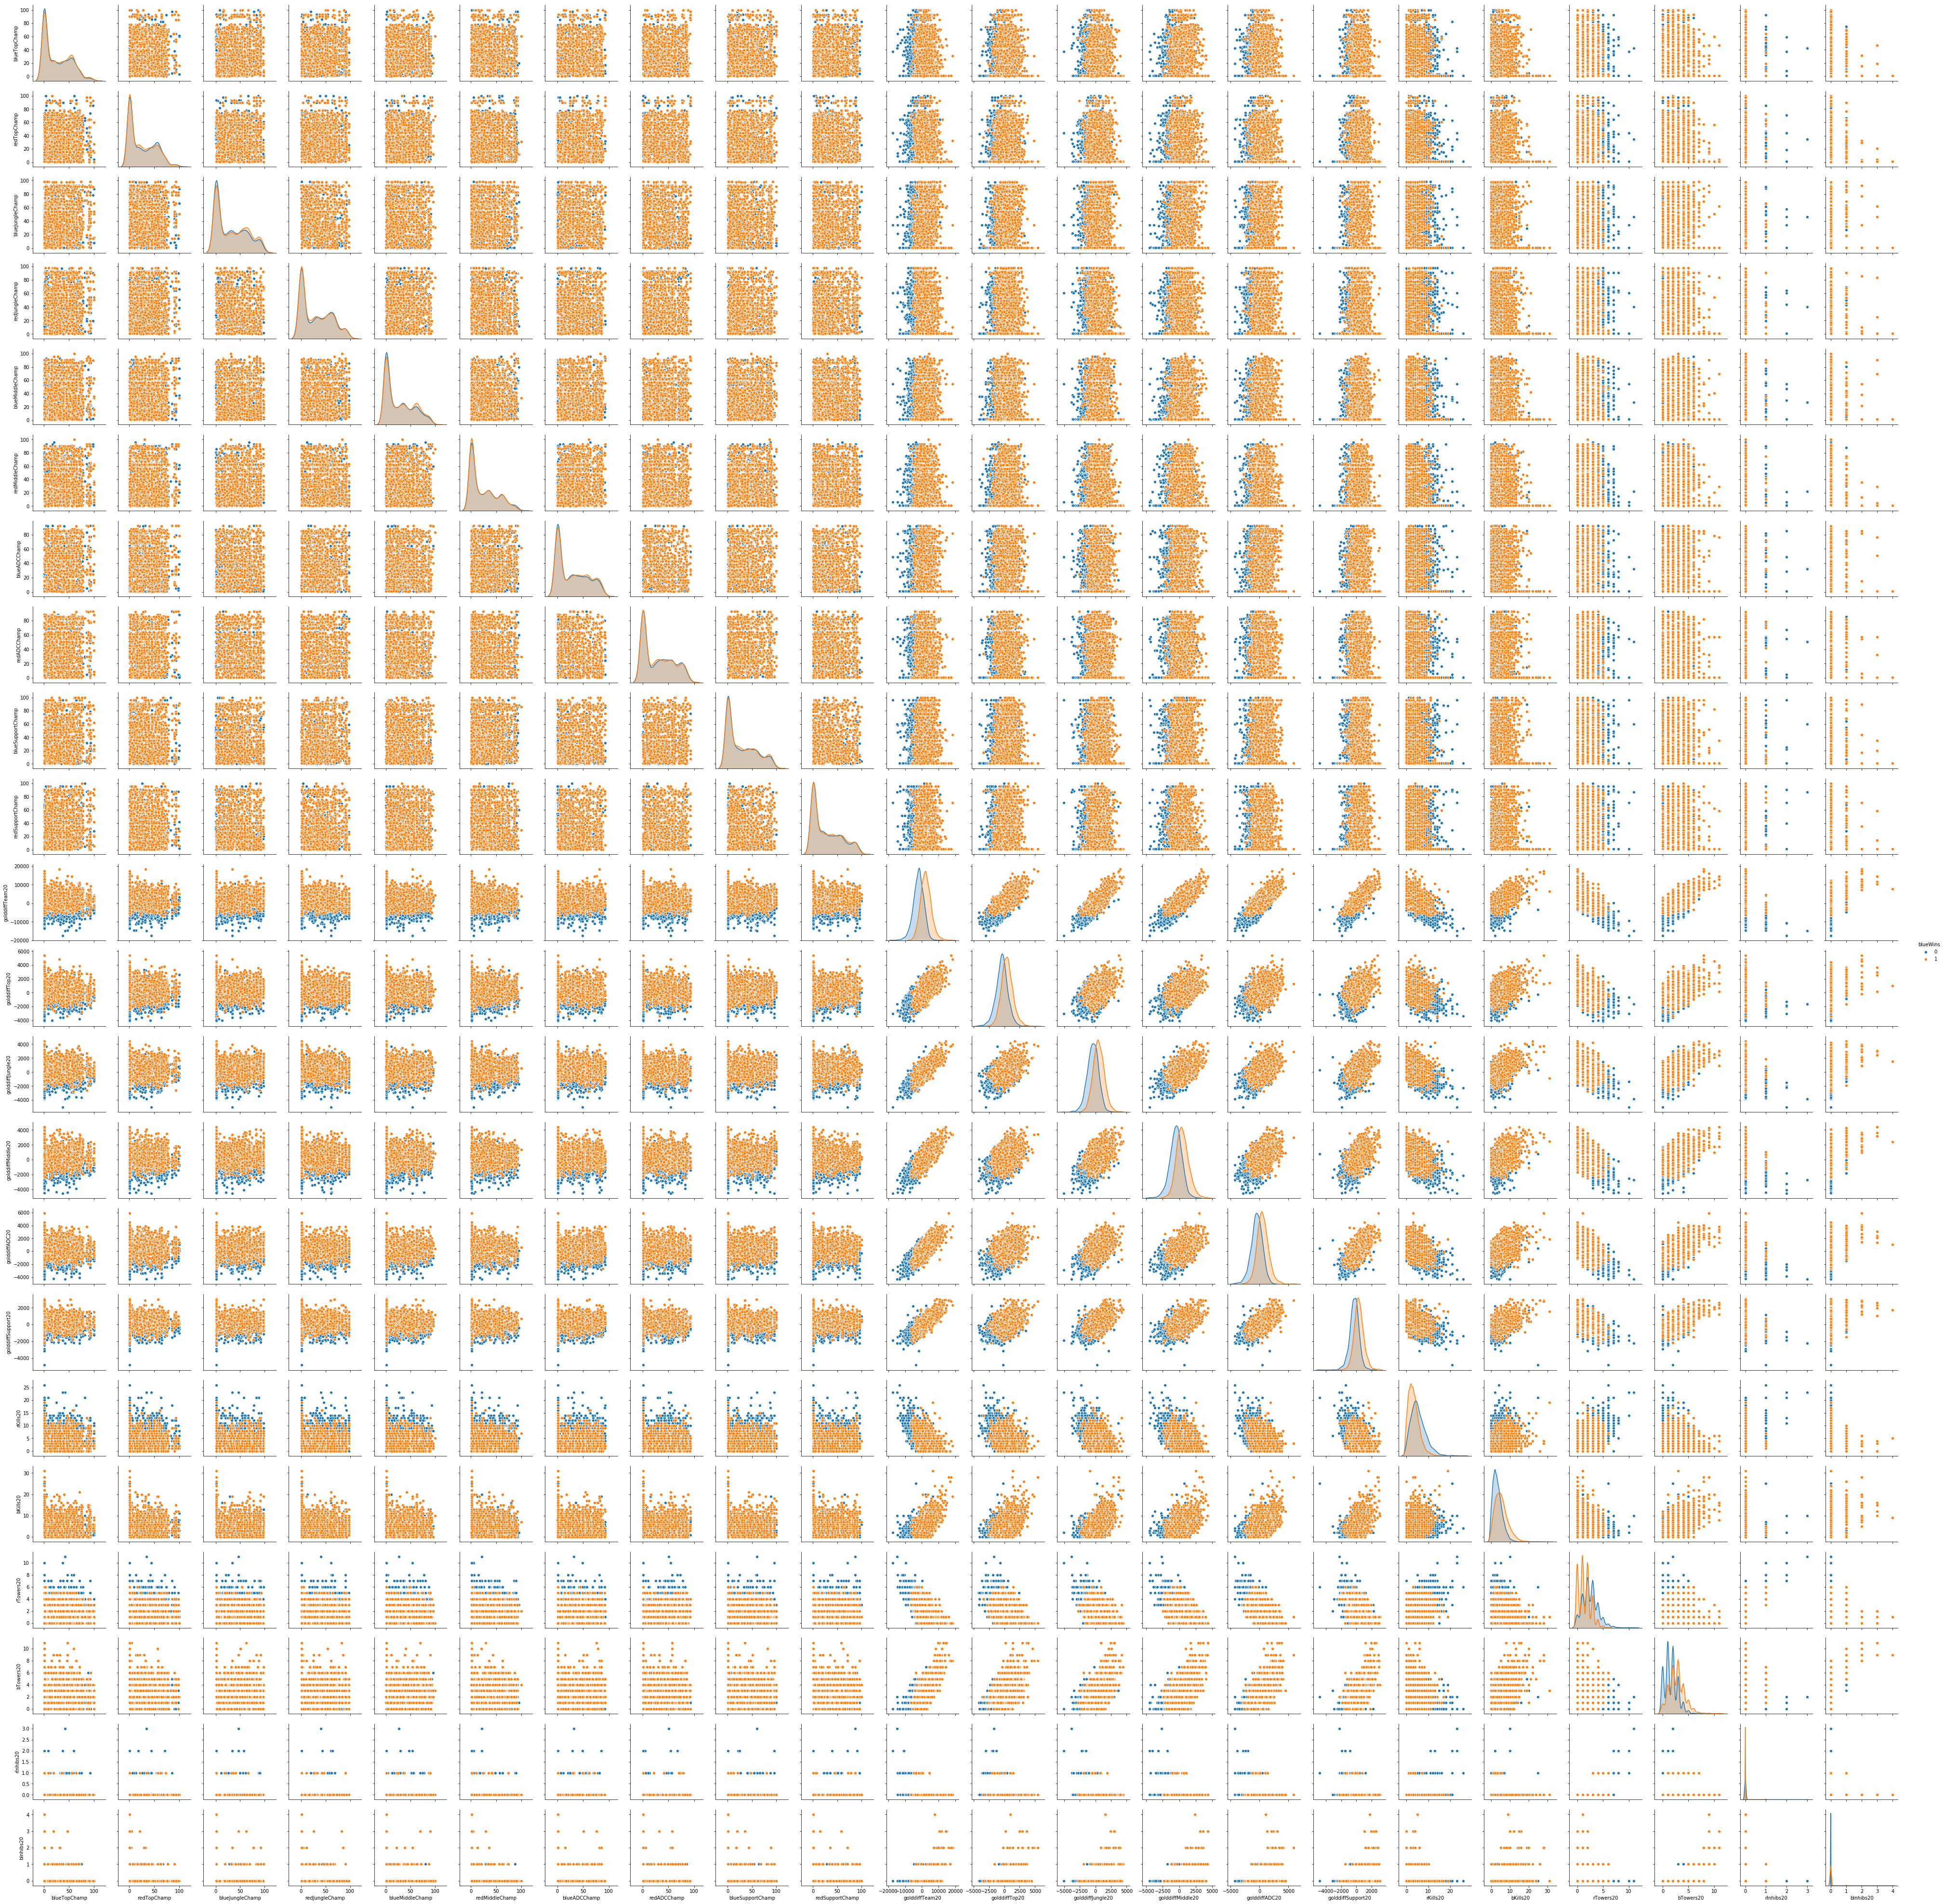

In [5]:
# Distribuições dos atributos numéricos
sns.pairplot(data=lol_early, x_vars=lol_early.columns[3:], y_vars=lol_early.columns[3:], hue="blueWins");

Pelos gráficos de dispersão dos pares de atributos, percebemos que as nossas classes não são linearmente separáveis.

---

## Feature Importances

A partir da construção de árvores de decisão, é possível atribuir valores de importância para cada atributo na tarefa de classificação. Isto é, um atributo de maior importância explica melhor a divisão entre as classes de interesse.

Vamos analisar a importância de cada feature em Random Forests de árvores com divisões feitas a partir da métrica de Entropia.

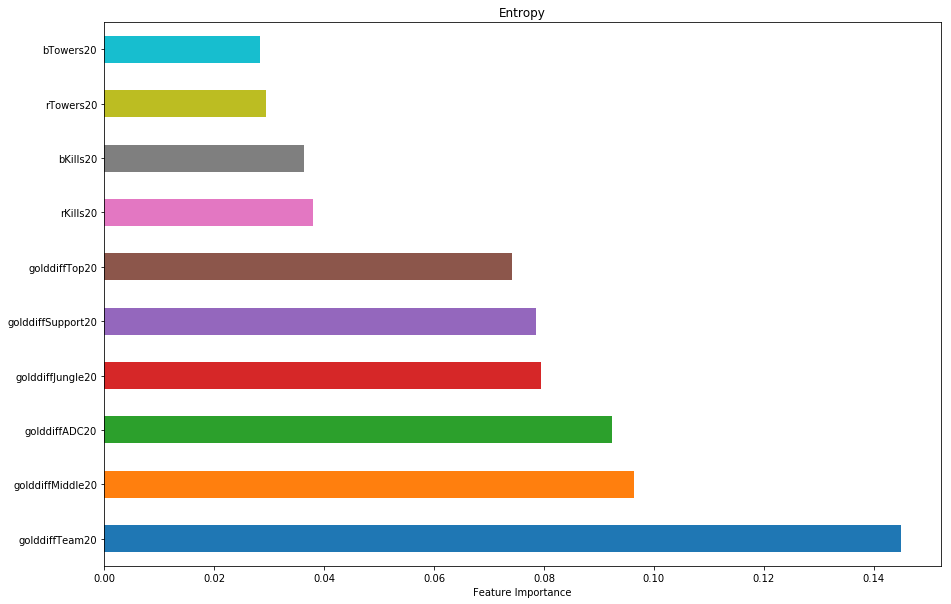

In [6]:
from sklearn.ensemble import RandomForestClassifier

X = pd.get_dummies(lol_early).iloc[:,1:]
y = lol_early.iloc[:,0]

tree = RandomForestClassifier(n_estimators=100, criterion='entropy')
tree = tree.fit(X,y)
feat_importances = pd.Series(tree.feature_importances_, index=X.columns)
ax = feat_importances.nlargest(10).plot(kind='barh', title="Entropy", figsize=(15,10))
ax.set_xlabel("Feature Importance");

Podemos ver que as diferenças em ouro são os atributos mais relevantes para as divisões, como esperado. Quanto maior uma vantagem criada no início do jogo, mais chance o time dominante tem de vencer.

É interessante notar que a diferença de ouro nas posições de Mid e ADC são as mais explicativas entre as diferenças em outras posições. Provavelmente porque têm maior impacto na conclusão de uma partida.

---

# Classificação

Como o nosso problema não é linearmente separável, de alta dimensionalidade, e com dados categóricos e contínuos, vamos construir uma Rede Neural Multicamadas para classificação.

In [7]:
X.columns

Index(['blueTopChamp', 'redTopChamp', 'blueJungleChamp', 'redJungleChamp',
       'blueMiddleChamp', 'redMiddleChamp', 'blueADCChamp', 'redADCChamp',
       'blueSupportChamp', 'redSupportChamp', 'golddiffTeam20',
       'golddiffTop20', 'golddiffJungle20', 'golddiffMiddle20',
       'golddiffADC20', 'golddiffSupport20', 'rKills20', 'bKills20',
       'rTowers20', 'bTowers20', 'rInhibs20', 'bInhibs20', 'league_CBLoL',
       'league_CLS', 'league_EULCS', 'league_IEM', 'league_LCK', 'league_LCL',
       'league_LJL', 'league_LLN', 'league_LMS', 'league_MSI', 'league_NALCS',
       'league_OPL', 'league_RR', 'league_TCL', 'league_WC',
       'season_2016 Spring', 'season_2016 Summer', 'season_2017 Spring',
       'season_2017 Summer'],
      dtype='object')

É importante que utilizemos dados normalizados. Então vamos Z-normalizá-los.

In [8]:
from sklearn.preprocessing import StandardScaler

# Z-Normalização
scaler = StandardScaler()
scaler = scaler.fit(X.iloc[:,0:19])
X.iloc[:,0:19] = scaler.transform(X.iloc[:,0:19])
X.head()

blueTopChamp  redTopChamp  blueJungleChamp  redJungleChamp  \
0     -0.833139    -0.881513         0.956778        0.192984   
1      0.680129    -0.916733        -0.344775        0.192984   
2     -0.430107     0.848139         0.221256       -0.314693   
3     -0.833139    -0.779769         0.138111        1.053682   
4      1.657290     0.049838         0.956778        1.352909   

   blueMiddleChamp  redMiddleChamp  blueADCChamp  redADCChamp  \
0         0.065212        0.284876     -0.805619     1.789865   
1        -0.406683        0.182325     -0.956831     0.961448   
2        -0.846646       -0.357015     -0.317617     0.961448   
3        -0.594732       -0.357015      1.778730     0.961448   
4         0.161010       -0.357015      0.957374     0.316739   

   blueSupportChamp  redSupportChamp         ...          league_MSI  \
0          1.018192         0.043632         ...                   0   
1          0.567776         0.256960         ...                   0   
2          1.018192         0.256960         ...                   0   
3          1.018192         0.256960         ...                   0   
4         -0.631077         1.048340         ...                   0   

   league_NALCS  league_OPL  league_RR  league_TCL  league_WC  \
0             1           0          0           0          0   
1             1           0          0           0          0   
2             1           0          0           0          0   
3             1           0          0           0          0   
4             1           0          0           0          0   

   season_2016 Spring  season_2016 Summer  season_2017 Spring  \
0                   1                   0                   0   
1                   1                   0                   0   
2                   1                   0                   0   
3                   1                   0                   0   
4                   1                   0                   0   

   season_2017 Summer  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  

[5 rows x 41 columns]

Vamos usar o Keras para construir o nosso modelo.

In [9]:
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Criação do modelo Keras da rede neural.
def create_model(dropout_rate=0.0, optimizer='adam'):
    model = Sequential()
    model.add(Dense(22, activation='relu', input_dim=41)) # O número de neurons na camada oculta foi escolhido por (input+output)/2
    model.add(Dropout(dropout_rate)) # Camada de Dropout
    model.add(Dense(2, activation='softmax')) # Ativação softmax para uso mais amplo da rede
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model)

Using TensorFlow backend.


Para escolha de hiperparâmetros, vamos explorar algumas opções, usando o objeto `GridSearchCV` do `scikit-learn`. Há ainda muitas possíveis escolhas de hiperparâmetros a serem explorados, mas por escopo do trabalho e limitações de tempo e hardware, vamos limitar o espaço de busca.

In [13]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Hiperparâmetros a serem explorados
param_grid = {
    'optimizer': ['SGD', 'Adam'],
    'batch_size': [40, 60],
    'epochs': [100],
    'dropout_rate': [0.0, 0.1, 0.2]
}

# Conversão dos dados para vetores numpy
Xl, yl = np.array(X), np.array(pd.get_dummies(y)) # Precisamos também codificar a classe alvo em one-hot

# Escolha do modelo de melhor resultado usando o GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=KFold(n_splits=3, shuffle=True), verbose=1, n_jobs=1)
grid_result = grid.fit(Xl, yl, validation_split=0.33, verbose=0)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


3870/3870 [==============================] - 0s 23us/step


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 10.6min finished


Best: 0.761413 using {'batch_size': 40, 'dropout_rate': 0.1, 'epochs': 100, 'optimizer': 'SGD'}


Agora que temos a melhor combinação de hiperparâmetros entre as exploradas, vamos analisar sua performance com uma validação cruzada 5-fold. Vamos mensurar a acurácia média e valor ROC AUC (uma vez que a rede tem valores de probabilidade como saída) dos folds.

Test scores - Accuracy: 0.7769164513350559 ROC AUC: 0.8549468524931991
Test scores - Accuracy: 0.7484926787252368 ROC AUC: 0.8445784567735788
Test scores - Accuracy: 0.7665805340223945 ROC AUC: 0.850554629679408
Test scores - Accuracy: 0.7614125753660638 ROC AUC: 0.852856598516331
Test scores - Accuracy: 0.7846683893195521 ROC AUC: 0.860032978183663


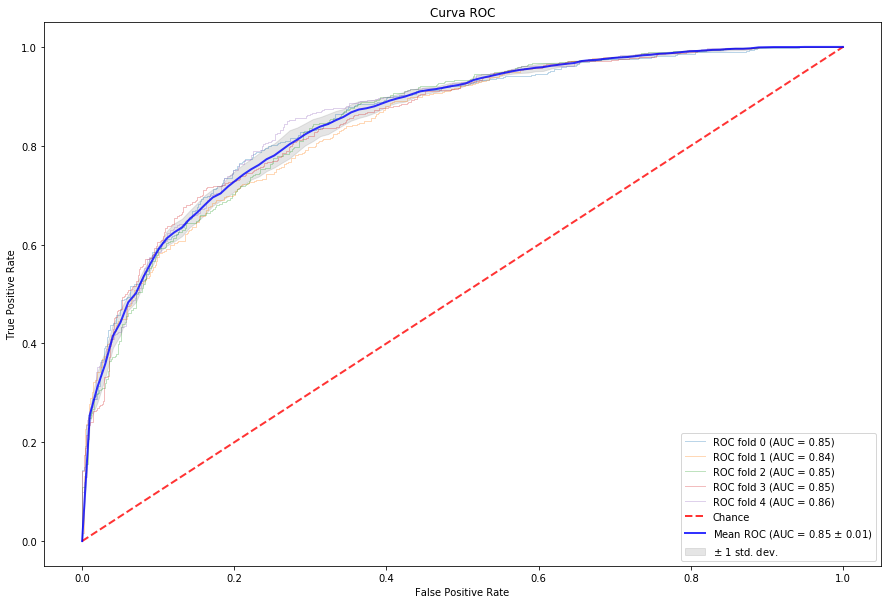

Acurácia média: 0.767614


In [36]:
from scipy import interp
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(15,10))

# Objeto KFold
kf = KFold(n_splits=5, shuffle=True)

# Listas para coleta de métricas de performance dos folds
accs = [] # Acurácias
tprs = [] # True Positive Rates
aucs = [] # Áreas abaixo da curva
mean_fpr = np.linspace(0, 1, 100) # Média da False Positive Rate

# Modelo
model = create_model(dropout_rate=0.1, optimizer="SGD")

i=0
# Cross-Validation
for train_index, test_index in kf.split(Xl, yl):
    model.fit(Xl[train_index], yl[train_index], epochs=100, batch_size=40, verbose=0)
    probas_ = model.predict(Xl[test_index])
    accs.append(accuracy_score(y[test_index], np.argmax(probas_, axis=1))) # Acurácia
    # Cálculo da curva ROC e área abaixo da curva (AUC)
    fpr, tpr, thresholds = roc_curve(y[test_index], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr) # Valor ROC AUC
    aucs.append(roc_auc)
    # Plot da curva ROC para o fold
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    print("Test scores - Accuracy: %s ROC AUC: %s" % (accs[-1], roc_auc))
    i+=1
    

# Plot da Chance    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

# Plot da curva ROC média
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

# Plot do desvio padrão das curvas ROC
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

# Legendas do plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()
print("Acurácia média: %f" % (np.array(accs).mean()))

---
# Classificação exclusivamente com dados do contexto da partida

In [46]:
lol_draft = lol_early.drop(lol_early.columns[13:], axis=1)

In [48]:
len(pd.get_dummies(lol_draft).columns)

30

In [52]:
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout

Xd = pd.get_dummies(lol_draft).iloc[:,1:]
yd = lol_draft.iloc[:,0]

# Criação do modelo Keras da rede neural.
def create_model(dropout_rate=0.0, optimizer='adam'):
    model = Sequential()
    model.add(Dense(16, activation='relu', input_dim=29)) # O número de neurons na camada oculta foi escolhido por (input+output)/2
    model.add(Dropout(dropout_rate)) # Camada de Dropout
    model.add(Dense(2, activation='softmax')) # Ativação softmax para uso mais amplo da rede
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

Para escolha de hiperparâmetros, vamos explorar algumas opções, usando o objeto `GridSearchCV` do `scikit-learn`. Há ainda muitas possíveis escolhas de hiperparâmetros a serem explorados, mas por escopo do trabalho e limitações de tempo e hardware, vamos limitar o espaço de busca.

Test scores - Accuracy: 0.5607235142118863 ROC AUC: 0.49868866889341734
Test scores - Accuracy: 0.5615848406546081 ROC AUC: 0.5342248727447968
Test scores - Accuracy: 0.5434969853574505 ROC AUC: 0.5358416313875142
Test scores - Accuracy: 0.553832902670112 ROC AUC: 0.5413654978626731
Test scores - Accuracy: 0.5116279069767442 ROC AUC: 0.5199809959319416


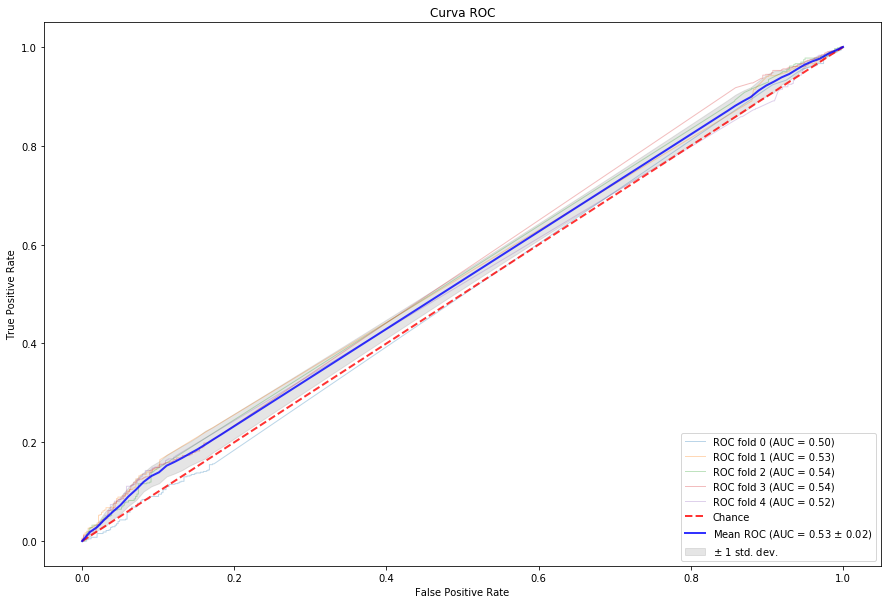

Acurácia média: 0.546253


In [53]:
from scipy import interp
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(15,10))

# Objeto KFold
kf = KFold(n_splits=5, shuffle=True)

# Listas para coleta de métricas de performance dos folds
accs = [] # Acurácias
tprs = [] # True Positive Rates
aucs = [] # Áreas abaixo da curva
mean_fpr = np.linspace(0, 1, 100) # Média da False Positive Rate

# Modelo
model = create_model(dropout_rate=0.1, optimizer="SGD")

# Conversão dos dados para vetores numpy
Xdl, ydl = np.array(Xd), np.array(pd.get_dummies(yd)) # Precisamos também codificar a classe alvo em one-hot

i=0
# Cross-Validation
for train_index, test_index in kf.split(Xdl, ydl):
    model.fit(Xdl[train_index], ydl[train_index], epochs=100, batch_size=40, verbose=0)
    probas_ = model.predict(Xdl[test_index])
    accs.append(accuracy_score(yd[test_index], np.argmax(probas_, axis=1))) # Acurácia
    # Cálculo da curva ROC e área abaixo da curva (AUC)
    fpr, tpr, thresholds = roc_curve(yd[test_index], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr) # Valor ROC AUC
    aucs.append(roc_auc)
    # Plot da curva ROC para o fold
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    print("Test scores - Accuracy: %s ROC AUC: %s" % (accs[-1], roc_auc))
    i+=1
    

# Plot da Chance    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

# Plot da curva ROC média
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

# Plot do desvio padrão das curvas ROC
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

# Legendas do plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()
print("Acurácia média: %f" % (np.array(accs).mean()))

---
# Classificação exclusivamente com dados de placar aos 20 minutos

In [58]:
lol_vals = lol_early.drop(lol_early.columns[1:13], axis=1)

In [59]:
len(pd.get_dummies(lol_vals).columns)

13

In [60]:
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout

Xv = pd.get_dummies(lol_vals).iloc[:,1:]
yv = lol_vals.iloc[:,0]

# Criação do modelo Keras da rede neural.
def create_model(dropout_rate=0.0, optimizer='adam'):
    model = Sequential()
    model.add(Dense(7, activation='relu', input_dim=12)) # O número de neurons na camada oculta foi escolhido por (input+output)/2
    model.add(Dropout(dropout_rate)) # Camada de Dropout
    model.add(Dense(2, activation='softmax')) # Ativação softmax para uso mais amplo da rede
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

Test scores - Accuracy: 0.7605512489233419 ROC AUC: 0.7618866240142836
Test scores - Accuracy: 0.7639965546942291 ROC AUC: 0.7654910447761194
Test scores - Accuracy: 0.7450473729543498 ROC AUC: 0.7469419782979105
Test scores - Accuracy: 0.751937984496124 ROC AUC: 0.7566033594139969
Test scores - Accuracy: 0.7596899224806202 ROC AUC: 0.7624109014675053


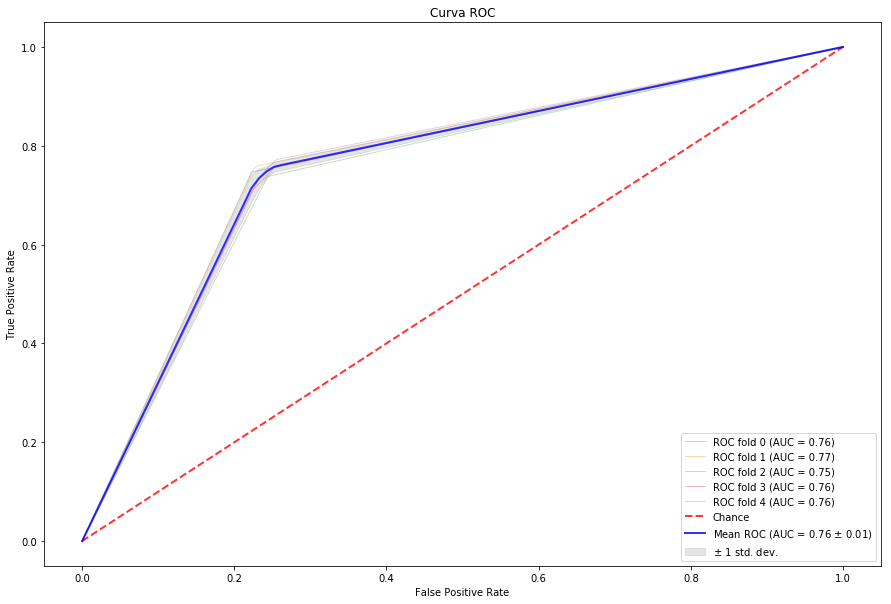

Acurácia média: 0.756245


In [62]:
from scipy import interp
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(15,10))

# Objeto KFold
kf = KFold(n_splits=5, shuffle=True)

# Listas para coleta de métricas de performance dos folds
accs = [] # Acurácias
tprs = [] # True Positive Rates
aucs = [] # Áreas abaixo da curva
mean_fpr = np.linspace(0, 1, 100) # Média da False Positive Rate

# Modelo
model = create_model(dropout_rate=0.1, optimizer="SGD")

# Conversão dos dados para vetores numpy
Xvl, yvl = np.array(Xv), np.array(pd.get_dummies(yv)) # Precisamos também codificar a classe alvo em one-hot

i=0
# Cross-Validation
for train_index, test_index in kf.split(Xvl, yvl):
    model.fit(Xvl[train_index], yvl[train_index], epochs=100, batch_size=40, verbose=0)
    probas_ = model.predict(Xvl[test_index])
    accs.append(accuracy_score(yv[test_index], np.argmax(probas_, axis=1))) # Acurácia
    # Cálculo da curva ROC e área abaixo da curva (AUC)
    fpr, tpr, thresholds = roc_curve(yv[test_index], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr) # Valor ROC AUC
    aucs.append(roc_auc)
    # Plot da curva ROC para o fold
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    print("Test scores - Accuracy: %s ROC AUC: %s" % (accs[-1], roc_auc))
    i+=1
    

# Plot da Chance    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

# Plot da curva ROC média
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

# Plot do desvio padrão das curvas ROC
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

# Legendas do plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()
print("Acurácia média: %f" % (np.array(accs).mean()))

---

# Conclusão e Perspectivas

Conseguimos um modelo de predição razoável com os dados de prioridade dos picks e dos primeiros 20 minutos de jogo. A partir apenas do contexto das partidas ou das vantagens criadas em 20 minutos, o classificador tem resultados medíocres.

Para construção de um modelo mais robusto, ainda há várias opções a serem exploradas:
- Diferentes configurações de camadas para a rede neural
- Exploração de mais combinações de hiperparâmetros da rede neural
- Representação categórica de campeões e consideração de suas características
    - O modelo construído no trabalho não captura a relação entre campeões específicos, nem características decisivas (como, por exemplo, se ele tem estilo de jogo orientado a um certo período da partida).
- Coleta de dados de mais partidas profissionais